In [1]:
%matplotlib inline
%autosave 300
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
import wave
import pyaudio
from audio2numpy import open_audio
from IPython.display import Audio
from scipy import signal
from scipy.fftpack import fft,fftshift
from scipy.io.wavfile import write
from scipy.signal import  firwin, freqz, firwin2, butter, lfilter

Autosaving every 300 seconds


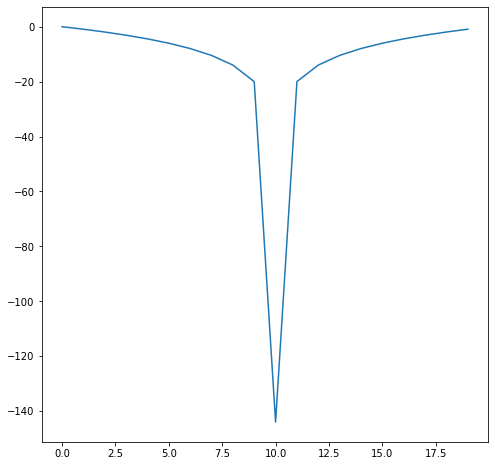

In [2]:
# This script demonstrates the process of converting
# the linear amplitude of a signal to a decibel scale.
# An additional step is included to prevent values
# of negative infinity from happening
x = np.arange(-1,1,0.1) # Linear amplitude values over FS range
N = len(x)
x_dB = np.zeros(N)
for n in range(N):
    x_dB[n] = 20 * np.log10(abs(x[n])) # Convert to dB
    if x_dB[n] < -144: # Conditional to prevent
        x_dB[n] = -144 #values of negative infinity
                        #or anything below noise floor

plt.plot(x_dB)
# This plot shows the result of the initial block in the detection
# path converting a linear amplitude to a decibel amplitude


Text(0, 0.5, 'Output Amplitude (dBFS)')

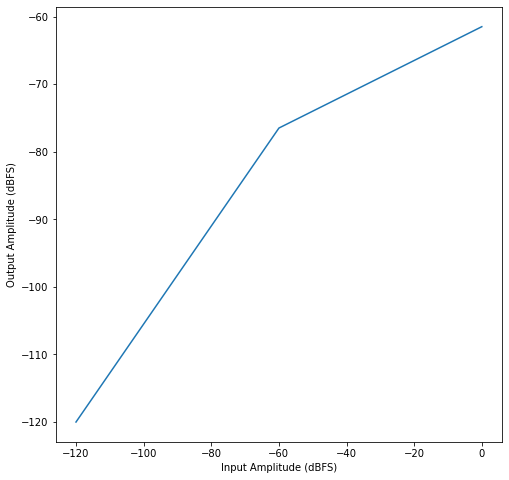

In [3]:
# This script demonstrates how to use the static
# characteristics of a compressor as part of
# the detection path. At the end of the script,
# the characteristic curve is plotted for the
# static characteristics.
x = np.arange(0.000001,1,0.001) #Simple input signal
N = len(x)
x_dB = np.zeros(N)
g_sc = np.zeros(N)

# Initialize static characteristics
T = -82 # Threshold (dBFS)
R = 4 # Ratio (4:1)
for n in range(N):
    x_dB[n] = 20 * np.log10(abs(x[n]))
    
    if x_dB[n] < -144:
        x_dB[n] = -144

    # Comparison to threshold
    if x_dB[n] > T:
        # Perform compression
        g_sc[n] = T + ((x_dB[n] - T)/R)
    else:
        #Do not compress
        g_sc[n] = x_dB[n]

plt.plot(x_dB,g_sc) # Compressor characteristic curve plot
plt.xlabel('Input Amplitude (dBFS)')
plt.ylabel('Output Amplitude (dBFS)')


Text(0, 0.5, 'Output Amplitude (dBFS)')

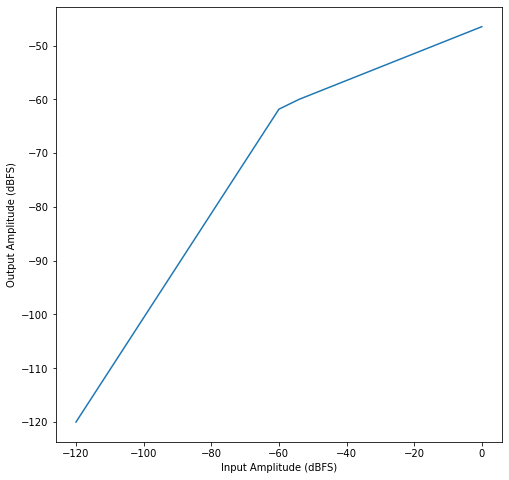

In [4]:
# This script demonstrates how to incorporate
# the knee parameter to create a soft–knee compressor.
# At the end of the script, the characteristic curve
# is plotted for the static characteristics.

x = np.arange(0.000001,1,0.001) #Simple input signal
N = len(x)
T = -62
R = 4
W = 10 # Knee width, 4 dB

x_dB = np.zeros(N)
g_sc = np.zeros(N)

for n in range(N):
    x_dB[n] = 20 * np.log10(abs(x[n]))
    if x_dB[n] < -144:
        x_dB[n] = -144
    
    # Comparison to threshold
    if x_dB[n] > (T + W/2):
        # Above knee curve
        g_sc[n] = T + ((x_dB[n] - T)/R)
    elif x_dB[n] > (T - W/2):
        # Within knee curve
        g_sc[n] = x_dB[n] + ((1/R - 1)*(x_dB[n] - T + W/2)**2)/(2 * W)
    else:
        # Do not compress
        g_sc[n] = x_dB[n]

plt.plot(x_dB,g_sc) # Compressor characteristic curve plot
plt.xlabel('Input Amplitude (dBFS)')
plt.ylabel('Output Amplitude (dBFS)')


### response time

#### step demo

In [5]:
# STEPDEMO
# This script demonstrates the process of measuring
# the step response of a 1st-order, feed-back LPF.
# A plot is created showing a comparison between
# the input step signal and the output response.

# Initialize the Sampling Rate
Fs = 48000
Ts = 1/Fs

# Create Step Input Signal
x = np.concatenate((np.zeros(Fs),np.ones(Fs)))
N = len(x)
y=np.zeros(N)

# Initialize gain value
alpha = 0.9995#  Also try values between 0.999-0.9999
q = 0 # Initialize feedback variable
for n in range(N):
    y[n] = (1-alpha) * x[n] + alpha * q
    q = y[n] # Stores the "previous" value for the next loop cycle


Text(0.5, 0, 'Time (sec.)')

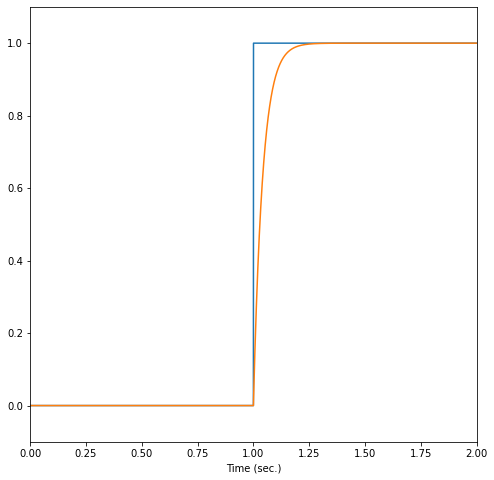

In [6]:
t = np.arange(0,N)*Ts # Time vector for plot
plt.plot(t,x,t,y)
plt.axis([0, 2, -0.1, 1.1])
plt.xlabel('Time (sec.)')
#legend('Step Input','Output');

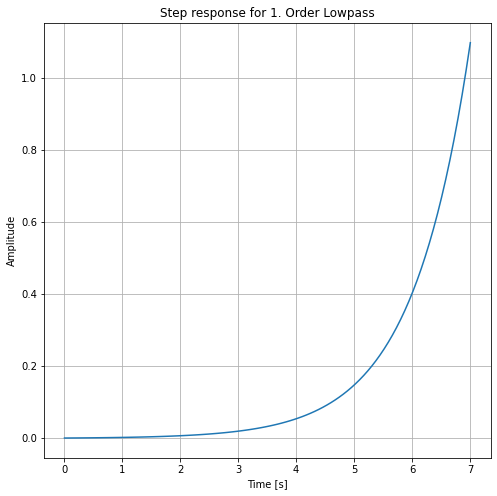

In [12]:
sys = signal.lti([1-alpha],[1, -alpha])
#t, y = step2(sys)
t, y = signal.step(sys)
plt.plot(t, y)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Step response for 1. Order Lowpass')
plt.grid()

Text(0.5, 0, 'Time (sec.)')

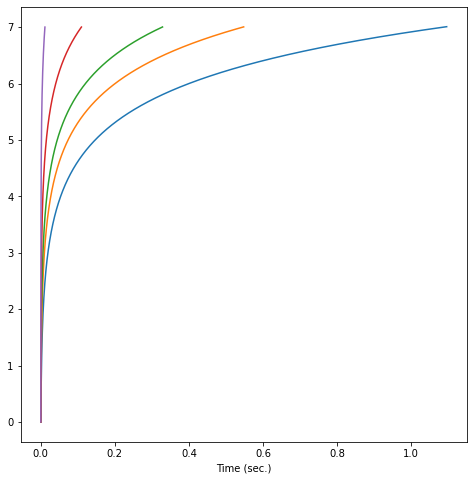

In [22]:
# STEPRESPONSE
# This script demonstrates the built-in,
# MATLAB function: stepz(b,a). The step 
# response for several first-order systems
# is compared using different feed-back gains.

# See also STEPZ

Fs = 48000 # Initialize the Sampling Rate
sec = 1   # Time length in seconds
n = sec*Fs # Convert seconds to # of samples

# Define different gain values to test
gains = np.array([0.999,0.9995,0.9997,0.9999, 0.99999])

# Determine a new step response each time through the loop
for element in range(len(gains)): 
    alpha = gains[element]
    sys = signal.lti([1-alpha],[1, -alpha])
    #b = (1-alpha)
    #a = [1 , -alpha]
    h,t = signal.step(sys, N=n )
    plt.plot(t,h)


#plt.axis([0, sec, -0.1, 1.1])
plt.xlabel('Time (sec.)')
#AX = legend('.9990','.9995','.9997','.9999');set(AX,'FontSize',12);

### basic comp

(0.0, 3.0, -0.1, 1.1)

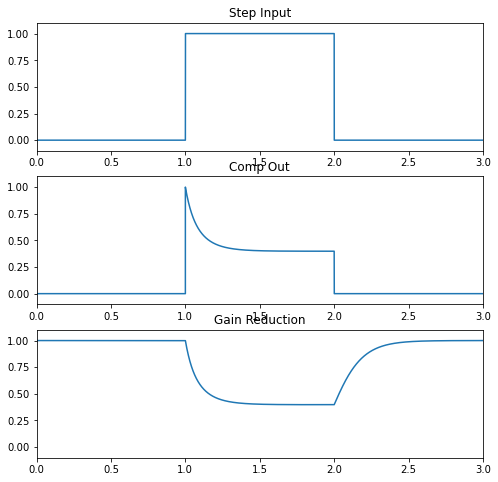

In [26]:
# BASICCOMP
# This script creates a dynamic range compressor with
# attack and release times linked together. A step
# input signal is synthesized for testing. A plot
# is produced at the end of the script to show
# a comparison of the input step signal, the output
# response, and the gain reduction curve.
#
# See also COMPRESSOR, COMPRESSOREXAMPLE

# Step Input Signal
Fs = 48000
Ts = 1/Fs
x = np.concatenate((np.zeros(Fs), np.ones(Fs), np.zeros(Fs)))
N = len(x)

# Parameters for Compressor
T = -12   # Threshold = -12 dBFS
R = 3     # Ratio = 3:1
responseTime = 0.25  # time in seconds
alpha = np.exp(-np.log(9)/(Fs * responseTime))
gainSmoothPrev = 0 # Initialize smoothing variable

y = np.zeros(N)
lin_A = np.zeros(N)
# Loop over each sample to see if it is above thresh
for n in range(N):
    ##### Calculations of the Detection Path
    # Turn the input signal into a uni-polar signal on the dB scale
    x_uni = np.abs(x[n])
    x_dB = 20*np.log10((x_uni+0.000001)/1)
    # Ensure there are no values of negative infinity
    if x_dB < -96:
        x_dB = -96
    
    # Static Characteristics
    if x_dB > T:
        gainSC = T + (x_dB - T)/R # Perform Downwards Compression
    else:
        gainSC = x_dB # Do not perform compression 
          
    gainChange_dB = gainSC - x_dB
    
    # smooth over the gainChange_dB to alter Response Time
    gainSmooth =  ((1-alpha)*gainChange_dB) + (alpha*gainSmoothPrev)

    # Convert to linear amplitude scalar
    lin_A[n] = 10**(gainSmooth/20)
    
    #### Apply linear amplitude from Detection Path
    #### to input sample
    y[n] = lin_A[n] * x[n]
    
    # Update gainSmoothPrev used in the next sample of the loop
    gainSmoothPrev = gainSmooth;

t = np.arange(0,N)*Ts
#t = t(:);

plt.subplot(3,1,1)
plt.plot(t,x)
plt.title('Step Input')
plt.axis([0, 3, -0.1, 1.1]) 
plt.subplot(3,1,2)
plt.plot(t,y)
plt.title('Comp Out')
plt.axis([0, 3, -0.1, 1.1])
plt.subplot(3,1,3)
plt.plot(t,lin_A)
plt.title('Gain Reduction')
plt.axis([0, 3, -0.1, 1.1])

### compressor example

In [29]:
# COMPRESSOR
# This function implements a dynamic range compressor 
# with separate attack and release times. To visualize
# the results, code is included at the end of the function
# to plot the input signal and the compressed output signal.
# As a default, this code is commented so it does not create
# a plot each time the function is called.
#
# Input Variables
#   T : threshold relative to 0 dBFS
#   R : ratio (R to 1)
#   attackTime : units of seconds
#   releaseTime : units of seconds
# 
# See also COMPRESSOREXAMPLE, BASICCOMP

def compressor(x,Fs,T,R,attackTime,releaseTime):
    N = len(x)
    y = np.zeros(N)
    lin_A = np.zeros(N)

    # Initialize separate attack and release times
    alphaA = np.exp(-np.log(9)/(Fs * attackTime))
    alphaR = np.exp(-np.log(9)/(Fs * releaseTime))

    gainSmoothPrev = 0 # Initialize smoothing variable

    # Loop over each sample to see if it is above thresh
    for n in range(N):
        # Turn the input signal into a uni-polar signal on the dB scale
        x_uni = abs(x[n])
        x_dB = 20*np.log10((x_uni+0.0000001)/1)
        # Ensure there are no values of negative infinity
        if x_dB < -96:
            x_dB = -96

        # Static Characteristics
        if x_dB > T:
            gainSC = T + (x_dB - T)/R # Perform Downwards Compression
        else: 
            gainSC = x_dB # Do not perform compression 

        gainChange_dB = gainSC - x_dB

        # smooth over the gainChange
        if gainChange_dB < gainSmoothPrev:
            # attack mode
            gainSmooth = ((1-alphaA)*gainChange_dB)+(alphaA*gainSmoothPrev)
        else:
            # release
            gainSmooth = ((1-alphaR)*gainChange_dB) +(alphaR*gainSmoothPrev)

        # Convert to linear amplitude scalar
        lin_A[n] = 10**(gainSmooth/20)

        # Apply linear amplitude to input sample
        y[n] = lin_A[n] * x[n]

        # Update gainSmoothPrev used in the next sample of the loop
        gainSmoothPrev = gainSmooth

    # Uncomment for visualization
    t = np.arange(0,N)/Fs
    #t = t(:);
    plt.subplot(2,1,1)
    plt.plot(t,x)
    plt.title('Input')
    plt.axis([0, t[-1], -1.1, 1.1]) 
    plt.subplot(2,1,2)
    plt.plot(t,y,t,lin_A)
    plt.title('Output')
    plt.axis([0, t[-1], -1.1, 1.1])
    # legend('Output Signal','Gain Reduction');
    
    return y


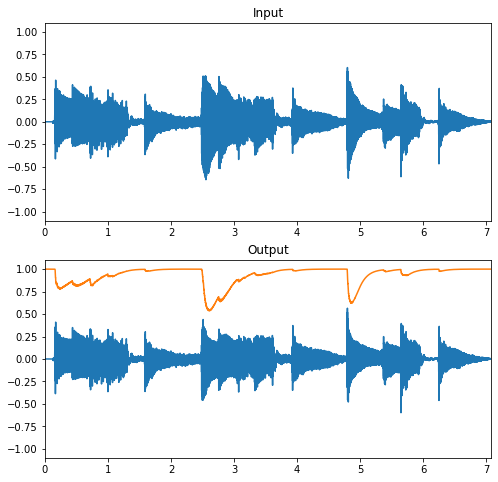

In [30]:
# COMPRESSOREXAMPLE
# This script creates a dynamic range compressor with
# separate attack and release times 
# 
# See also COMPRESSOR, BASICCOMP

# Acoustic Guitar "Audio" Sound file
filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

# Parameters for Compressor
T = -15   # Threshold = -15 dBFS
R = 10     # Ratio = 10:1

# Initialize separate attack and release times
attackTime = 0.05  # time in seconds
releaseTime = 0.25  # time in seconds

# Compressor Function
out = compressor(inx,Fs,T,R,attackTime,releaseTime)



In [31]:
Audio(out,rate=Fs)

### feedback detection

In [41]:
# FEEDBACKCOMP
# This script creates a feed-back compressor.
# The processing of the detection path is similar
# to the feed-forward compressor. The main difference
# is the output, "y" is analyzed in the detection 
# path, not the input "x". A plot is produced
# at the end of the script to visualize the result.
#
# See also COMPRESSOR, BASICCOMP

# Acoustic Guitar "Audio" Sound file
filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

# Parameters for Compressor
T = -15   # Threshold = -15 dBFS
R = 10    # Ratio = 10:1

# Initialize separate attack and release times
attackTime = 0.05  # time in seconds
alphaA = np.exp(-np.log(9)/(Fs * attackTime))
releaseTime = 0.25  # time in seconds
alphaR = np.exp(-np.log(9)/(Fs * releaseTime))

gainSmoothPrev = 0 # Initialize smoothing variable

y_prev = 0 # Initialize output for feed-back detection

N = len(inx)
y = np.zeros(N)
lin_A = np.zeros(N)

# Loop over each sample to see if it is above thresh
for n in range(N):
    ###### Detection path based on the output signal, not "x"
    # Turn the input signal into a uni-polar signal on the dB scale
    y_uni = abs(y_prev)
    y_dB = 20*np.log10((y_uni+0.00001)/1)
    
    # Ensure there are no values of negative infinity
    if y_dB < -96:
        y_dB = -96
    
    # Static Characteristics
    if y_dB > T:
        gainSC = T + (y_dB - T)/R  # Perform Downwards Compression
    else:
        gainSC = y_dB # Do not perform compression 
          
    gainChange_dB = gainSC - y_dB
    
    # smooth over the gainChange
    if gainChange_dB < gainSmoothPrev:
        # attack mode
        gainSmooth = ((1-alphaA)*gainChange_dB)+(alphaA*gainSmoothPrev)
    else:
        # release
        gainSmooth = ((1-alphaR)*gainChange_dB)+(alphaR*gainSmoothPrev)

    # Convert to linear amplitude scalar
    lin_A[n] = 10**(gainSmooth/20)
    
    # Apply linear amplitude to input sample
    y[n] = lin_A[n] * inx[n]
    y_prev = y[n] # Update for next cycle
    
    # Update gainSmoothPrev used in the next sample of the loop
    gainSmoothPrev = gainSmooth



(0.0, 7.0, -1.1, 1.1)

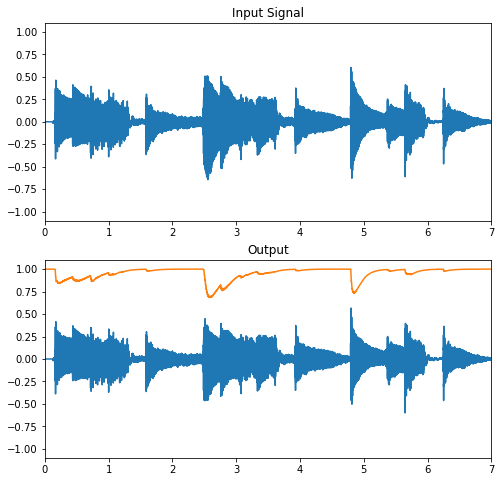

In [43]:
t = np.arange(0,N)/Fs
#t = t(:);

plt.subplot(2,1,1)
plt.plot(t,inx)
plt.title('Input Signal')
plt.axis([0, 7, -1.1, 1.1]) 
plt.subplot(2,1,2)
plt.plot(t,y,t,lin_A)
plt.title('Output')
plt.axis([0, 7, -1.1, 1.1])
#legend('Output Signal','Gain Reduction');

### rms comp

In [54]:
# RMSCOMP
# This script creates a compressor with 
# conventional RMS detection. The RMS value
# is calculated over a range of "M" samples.
# Note: attack and release are linked
#
# See also COMPRESSOR, RMSCOMP2

# Acoustic Guitar "Audio" Sound file
filename = "textbookcode-master\Ch_13\AcGtr.wav"
[x,Fs] = open_audio(filename)

# Parameters for Compressor
T = -20   # Threshold = -20 dBFS
R = 4     # Ratio = 4:1

# Initialize separate attack and release times
attackTime = 0.1  # time in seconds
alphaA = np.exp(-np.log(9)/(Fs * attackTime))
releaseTime = 0.25 # time in seconds
alphaR = np.exp(-np.log(9)/(Fs * releaseTime))

gainSmoothPrev = 0 # Initialize smoothing variable

M = 2048 # length of RMS calculation

# Initialize the first time window in a buffer
x_win = np.concatenate((np.zeros(int(M/2)),x[:(int(M/2))]))

N = len(x)
y = np.zeros(N)
lin_A = np.zeros(N)

# Loop over each sample to see if it is above thresh
for n in range(N):
    
    # Calculate the RMS for the current window
    x_rms = np.sqrt(np.mean(x_win**2))
    
    # Turn the input signal into a uni-polar signal on the dB scale
    x_dB = 20*np.log10(x_rms+0.000001)
    
    # Ensure there are no values of negative infinity
    if x_dB < -96:
        x_dB = -96

    # Static Characteristics
    if x_dB > T:
        gainSC = T + (x_dB - T)/R # Perform compression
    else:
        gainSC = x_dB # Do not perform compression 
          
    gainChange_dB = gainSC - x_dB
    
    # Convert to linear amplitude scalar
    lin_A[n] = 10**(gainChange_dB/20)
    
    # Apply linear amplitude to input sample
    y[n] = lin_A[n] * x[n]
    
    
    # Update the current time window
    if n+(M/2) < N:
        x_win = np.concatenate((x_win[1:], np.array([x[n+int(M/2)]])))
    else:
        x_win = np.concatenate((x_win[1:], np.zeros(1)))



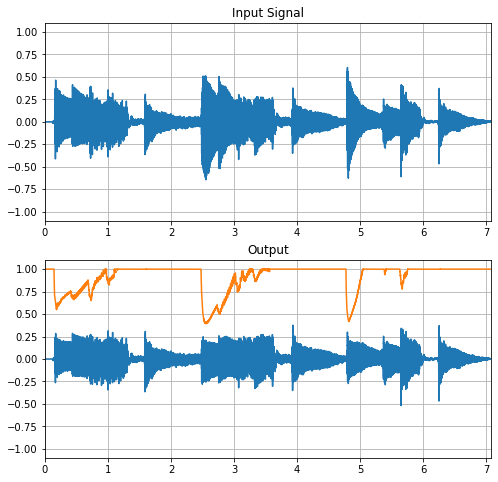

In [57]:
t = np.arange(0,N)/Fs

plt.subplot(2,1,1)
plt.plot(t,x)
plt.title('Input Signal')
plt.axis([0, t[-1], -1.1, 1.1]) 
plt.grid()
plt.subplot(2,1,2)
plt.plot(t,y,t,lin_A)
plt.title('Output')
plt.axis([0, t[-1], -1.1, 1.1])
plt.grid()
#legend('Output Signal','Gain Reduction');

### rmscomp2

In [62]:
# RMSCOMP2
# This script creates a compressor with approximated
# RMS detection. The RMS value is estimated
# by using feedback. Separate attack and release
# times can be achieved.
#
# See also RMSCOMP

# Acoustic Guitar "Audio" Sound file
filename = "textbookcode-master\Ch_13\AcGtr.wav"
[x,Fs] = open_audio(filename)

# Parameters for Compressor
T = -12   # Threshold = -12 dBFS
R = 4     # Ratio = 4:1

# Initialize separate attack and release times
attackTime = 0.1  # time in seconds
alphaA = np.exp(-np.log(9)/(Fs * attackTime))
releaseTime = 0.1  # time in seconds
alphaR = np.exp(-np.log(9)/(Fs * releaseTime))

gainSmoothPrev = 0 # Initialize smoothing variable

N = len(x)
y = np.zeros(N)
lin_A = np.zeros(N)
# Loop over each sample to see if it is above thresh
for n in range(N):
    
    # Turn the input signal into a uni-polar signal on the dB scale
    x_dB = 20*np.log10(abs(x[n]+0.00001))
    
    # Ensure there are no values of negative infinity
    if x_dB < -96:
        x_dB = -96
    
    # Static Characteristics
    if x_dB > T:
        gainSC = T + (x_dB - T)/R # Perform Downwards Compression
    else:
        gainSC = x_dB # Do not perform compression 
          
    gainChange_dB = gainSC - x_dB
    
    # smooth over the gainChange
    if gainChange_dB < gainSmoothPrev:
        # attack mode
        gainSmooth = -np.sqrt(((1-alphaA)*gainChange_dB**2)+(alphaA*gainSmoothPrev**2))
    else:
        # release
        gainSmooth = -np.sqrt(((1-alphaR)*gainChange_dB**2)+(alphaR*gainSmoothPrev**2))

    # Convert to linear amplitude scalar
    lin_A[n] = 10**(gainSmooth/20)
    
    # Apply linear amplitude to input sample
    y[n] = lin_A[n] * x[n]
    
    # Update gainSmoothPrev used in the next sample of the loop
    gainSmoothPrev = gainSmooth
   


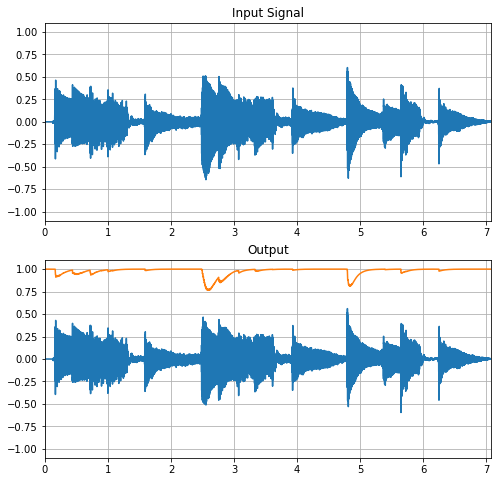

In [63]:
t = np.arange(0,N)/Fs

plt.subplot(2,1,1)
plt.plot(t,x)
plt.title('Input Signal')
plt.axis([0, t[-1], -1.1, 1.1]) 
plt.grid()
plt.subplot(2,1,2)
plt.plot(t,y,t,lin_A)
plt.title('Output')
plt.axis([0, t[-1], -1.1, 1.1])
plt.grid()

### side chain compressor

In [67]:
# SIDECHAINCOMP
# This script creates a side-chain compressor with
# a synthesizer signal and kick drum signal. 
#
# See also COMPRESSOR

# Synthesizer Input Signal
filename = "textbookcode-master\Ch_18\Synth.wav"
[x,Fs] = open_audio(filename)

# Kick Drum for the Detection Path
filename1 = "textbookcode-master\Ch_18\Kick.wav"
[sc,_] = open_audio(filename1)
#[sc] = audioread('Kick.wav');

# Parameters for Compressor
T = -24   # Threshold = -24 dBFS
R = 10     # Ratio = 10:1

# Initialize separate attack and release times
attackTime = 0.05  #time in seconds
alphaA = np.exp(-np.log(9)/(Fs * attackTime)) 
releaseTime = 0.25  # time in seconds
alphaR = np.exp(-np.log(9)/(Fs * releaseTime))

gainSmoothPrev = 0 # Initialize smoothing variable

N = len(sc)
y = np.zeros(N)
lin_A = np.zeros(N)
# Loop over each sample to see if it is above thresh
for n in range(N):
    ##### Detection path based on the Kick Drum input signal
    # Turn the input signal into a uni-polar signal on the dB scale
    sc_uni = abs(sc[n])
    sc_dB = 20*np.log10((sc_uni+0.000001)/1)
    # Ensure there are no values of negative infinity
    if sc_dB < -96:
        sc_dB = -96
    
    # Static Characteristics
    if sc_dB > T:
        gainSC = T + (sc_dB - T)/R # Perform Downwards Compression
    else: 
        gainSC = sc_dB # Do not perform compression 
          
    gainChange_dB = gainSC - sc_dB
    
    # smooth over the gainChange
    if gainChange_dB < gainSmoothPrev:
        # attack mode
        gainSmooth = ((1-alphaA)*gainChange_dB)+(alphaA*gainSmoothPrev)
    else:
        # release
        gainSmooth = ((1-alphaR)*gainChange_dB)+(alphaR*gainSmoothPrev)

    # Convert to linear amplitude scalar
    lin_A[n] = 10**(gainSmooth/20)
    
    # Apply linear amplitude to synthesizer input sample
    y[n] = lin_A[n] * x[n]
    
    # Update gainSmoothPrev used in the next sample of the loop
    gainSmoothPrev = gainSmooth

(0.0, 5.454541666666667, -1.1, 1.1)

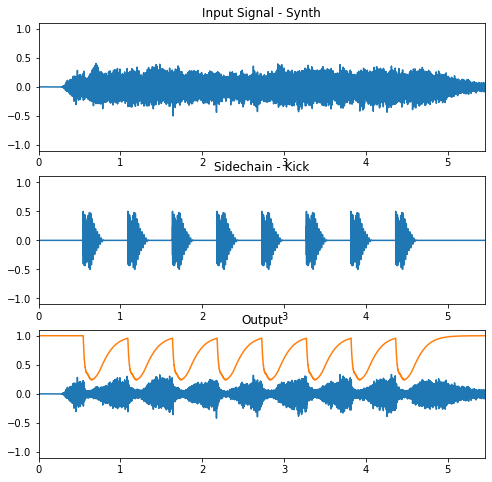

In [68]:
t = np.arange(0,N)/Fs

plt.subplot(3,1,1)
plt.plot(t,x)
plt.title('Input Signal - Synth')
plt.axis([0, t[-1], -1.1, 1.1]) 
plt.subplot(3,1,2)
plt.plot(t,sc)
plt.title('Sidechain - Kick')
plt.axis([0, t[-1], -1.1, 1.1])
plt.subplot(3,1,3)
plt.plot(t,y,t,lin_A)
plt.title('Output')
plt.axis([0, t[-1], -1.1, 1.1])
#legend('Output Signal','Gain Reduction');



In [69]:
Audio(y,rate=Fs)

### expander

#### gate

In [78]:
# EXPANDER
# This function implements an expander/gate DR processor.
# A similar approach is used to a compressor, except
# the static characteristics are calculated differently.
#
# Input Variables
#   T : threshold relative to 0 dBFS
#   R : ratio (R to 1)
#   attackTime : units of seconds
#   releaseTime : units of seconds
#
# See also EXPANDER, COMPRESSOREXAMPLE

def expander(x,Fs,T,R,attackTime,releaseTime):
    N = len(x)
    y = np.zeros(N)
    lin_A = np.zeros(N)

    # Calculate separate attack and release times
    alphaA = np.exp(-np.log(9)/(Fs * attackTime))
    alphaR = np.exp(-np.log(9)/(Fs * releaseTime))

    gainSmoothPrev = -144 # Initialize smoothing variable

    # Loop over each sample to see if it is below thresh
    for n in range(N):
        # Turn the input signal into a uni-polar signal on the dB scale
        x_uni = abs(x[n])
        x_dB = 20*np.log10((x_uni+0.00001)/1)
        # Ensure there are no values of negative infinity
        if x_dB < -144:
            x_dB = -144

        # Static Characteristics
        if x_dB > T:
            gainSC = x_dB # Do not perform expansion
        else:
            # Expander Calculation
            gainSC = T + (x_dB - T)*R  # Perform Downwards Expansion

            # Gating (Use Instead of Expander)
            #gainSC = -144
                    
        gainChange_dB = gainSC - x_dB

        # smooth over the gainChange
        if gainChange_dB > gainSmoothPrev:
            # attack mode
            gainSmooth = ((1-alphaA)*gainChange_dB)+(alphaA*gainSmoothPrev)
        else:
            # release
            gainSmooth = ((1-alphaR)*gainChange_dB)+(alphaR*gainSmoothPrev)

        # Convert to linear amplitude scalar
        lin_A[n] = 10**(gainSmooth/20)

        # Apply linear amplitude to input sample
        y[n] = lin_A[n] * x[n]

        # Update gainSmoothPrev used in the next sample of the loop
        gainSmoothPrev = gainSmooth

    t = np.arange(0,N)/Fs
    #t = t(:);

    plt.subplot(2,1,1)
    plt.plot(t,x)
    plt.title('Input Signal')
    plt.axis([0, 14, -1.1, 1.1]) 
    plt.subplot(2,1,2)
    plt.plot(t,y,t,lin_A)
    plt.title('Output')
    plt.axis([0, 14, -1.1, 1.1])
    #legend('Output Signal','Gain Reduction');

    return y

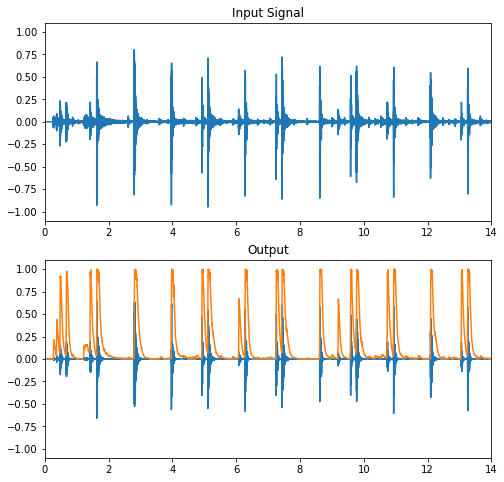

In [79]:
# EXPANDEREXAMPLE
# This script demonstrates an expander/gate DR processor

# See also EXPANDER, COMPRESSOREXAMPLE

# Drums sound file
filename = "textbookcode-master\Ch_18\monoDrums.wav"
[inx,Fs] = open_audio(filename)
#[in,Fs] = audioread('monoDrums.wav');

# Parameters for compressor
T = -20 # Threshold = –20 dBFS
R = 3 # Ratio = 3:1

# Initialize separate attack and release times
attackTime = 0.005 # time in seconds
releaseTime = 0.4 # time in seconds
out = expander(inx,Fs,T,R,attackTime,releaseTime)
Audio(out,rate=Fs)
#% sound(in,Fs); % For comparison


In [80]:
Audio(inx, rate=Fs)

In [81]:
# BIQUADFILTER
# This function implements a bi-quad filter based
# on the Audio EQ Cookbook Coefficients. All filter
# types can be specified (LPF, HPF, BPF, etc.) and
# three different topologies are included.
#
# Input Variables
#   f0 : filter frequency (cut-off or center based on filter)
#   Q : bandwidth parameter 
#   dBGain : gain value on the decibel scale
#   type : 'lpf','hpf','pkf','bp1','bp2','apf','lsf','hsf'
#   form : 1 (Direct Form I), 2 (DFII), 3 (Transposed DFII)

def biquadFilter(inx,Fs,f0,Q,dBGain,typex,form):

    ### Initial Parameters
    N = len(inx)
    out = np.zeros(N)

    ### Intermediate Variables
    #
    w0 = 2*np.pi*f0/Fs      # Angular Freq. (Radians/sample) 
    alpha = np.sin(w0)/(2*Q)     # Filter Width
    A  = np.sqrt(10**(dBGain/20))  #Amplitude

    #####
    ### TYPE - LPF,HPF,BPF,APF,HSF,LSF,PKF,NCH
    #
    #----------------------
    #        LPF
    #----------------------
    if typex =='lpf':
        b0 =  (1 - np.cos(w0))/2
        b1 =   1 - np.cos(w0)
        b2 =  (1 - np.cos(w0))/2
        a0 =   1 + alpha
        a1 =  -2*np.cos(w0)
        a2 =   1 - alpha

    #----------------------
    #        HPF
    #----------------------
    elif typex == 'hpf':
        b0 =  (1 + np.cos(w0))/2
        b1 = -(1 + np.cos(w0))
        b2 =  (1 + np.cos(w0))/2
        a0 =   1 + alpha
        a1 =  -2*np.cos(w0)
        a2 =   1 - alpha

    #----------------------
    #   Peaking Filter
    #----------------------
    elif typex == 'pkf':
        b0 =   1 + alpha*A
        b1 =  -2*np.cos(w0)
        b2 =   1 - alpha*A
        a0 =   1 + alpha/A
        a1 =  -2*np.cos(w0)
        a2 =   1 - alpha/A

    #----------------------
    #   Band-pass Filter 1
    #----------------------
    # Constant skirt gain, peak gain = Q
    elif typex == 'bp1':
        b0 =   np.sin(w0)/2
        b1 =   0
        b2 =  -np.sin(w0)/2
        a0 =   1 + alpha
        a1 =  -2*np.cos(w0)
        a2 =   1 - alpha

    #----------------------
    #   Band-pass Filter 2
    #----------------------
    # Constant 0 dB peak gain
    elif typex == 'bp2':
        b0 =   alpha
        b1 =   0
        b2 =  -alpha
        a0 =   1 + alpha
        a1 =  -2*np.cos(w0)
        a2 =   1 - alpha

    #----------------------
    #    Notch Filter
    #----------------------
    elif typex == 'nch':
        b0 =   1
        b1 =  -2*np.cos(w0)
        b2 =   1
        a0 =   1 + alpha
        a1 =  -2*np.cos(w0)
        a2 =   1 - alpha        

    #----------------------
    #    All-Pass Filter
    #----------------------
    elif typex == 'apf':
        b0 =   1 - alpha
        b1 =  -2*np.cos(w0)
        b2 =   1 + alpha
        a0 =   1 + alpha
        a1 =  -2*np.cos(w0)
        a2 =   1 - alpha

    #----------------------
    #    Low-Shelf Filter
    #----------------------
    elif typex == 'lsf':
        b0 = A*((A+1) - (A-1)*np.cos(w0) + 2*np.sqrt(A)*alpha)
        b1 = 2*A*((A-1) - (A+1)*np.cos(w0))
        b2 = A*((A+1) - (A-1)*np.cos(w0) - 2*np.sqrt(A)*alpha)
        a0 = (A+1) + (A-1)*np.cos(w0) + 2*np.sqrt(A)*alpha
        a1 = -2*((A-1) + (A+1)*np.cos(w0))
        a2 = (A+1) + (A-1)*np.cos(w0) - 2*np.sqrt(A)*alpha

    #----------------------
    #    High-Shelf Filter
    #----------------------
    elif typex == 'hsf':
        b0 = A*( (A+1) + (A-1)*np.cos(w0) + 2*np.sqrt(A)*alpha)
        b1 = -2*A*((A-1) + (A+1)*np.cos(w0))
        b2 = A*((A+1) + (A-1)*np.cos(w0) - 2*np.sqrt(A)*alpha)
        a0 = (A+1) - (A-1)*np.cos(w0) + 2*np.sqrt(A)*alpha
        a1 = 2*((A-1) - (A+1)*np.cos(w0))
        a2 = (A+1) - (A-1)*np.cos(w0) - 2*np.sqrt(A)*alpha

    # Otherwise, no filter
    else: 
        b0 = 1
        a0 = 1
        b1 = 0
        b2 = 0
        a1 = 0
        a2 = 0

    #####
    ### Topology - Direct Form I, II, Transposed II
    if (form == 1): # Direct Form I
        x2 = 0    # Initial conditions 
        x1 = 0
        y2 = 0
        y1 = 0
        for n in range(N):
            out[n] = (b0/a0)*inx[n] + (b1/a0)*x1 + (b2/a0)*x2 + (-a1/a0)*y1 + (-a2/a0)*y2
            x2 = x1
            x1 = inx[n]
            y2 = y1
            y1 = out[n]

    elif (form == 2): # Direct Form II
       w1 = 0     # w1 & w2 are delayed versions of 'w'
       w2 = 0
       for n in range(N):
           w = inx[n] + (-a1/a0)*w1 + (-a2/a0)*w2  
           out[n] = (b0/a0)*w + (b1/a0)*w1 + (b2/a0)*w2
           w2 = w1
           w1 = w

    elif (form == 3): # Transposed Direct Form II
       d1 = 0    # d1 & d2 are outputs of the delay blocks
       d2 = 0
       for n in range(N):
           out[n] = (b0/a0)*inx(n,1) + d1
           d1 = (b1/a0)*inx[n] + (-a1/a0)*out[n] + d2
           d2 = (b2/a0)*inx[n] + (-a2/a0)*out[n]

    else: # No filtering  

        out = inx


    return out

Text(0.5, 0, 'Time (sec.)')

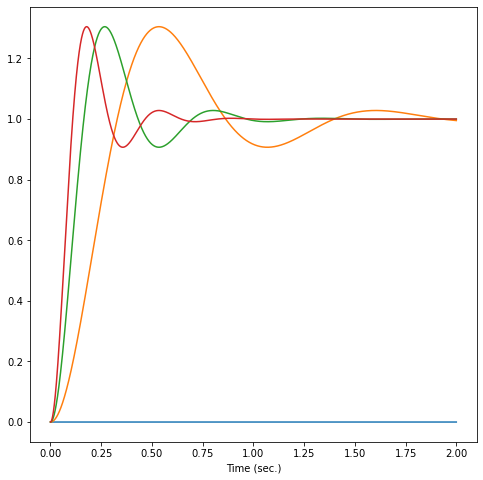

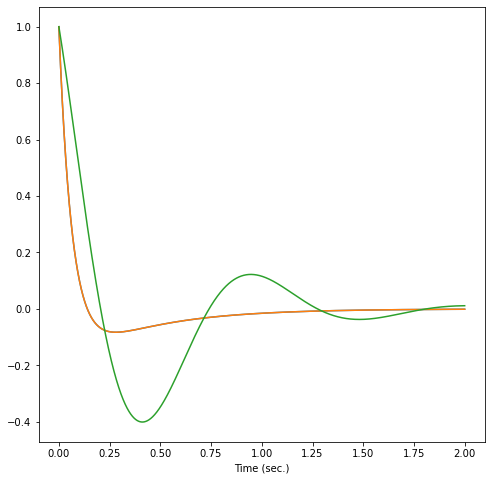

In [85]:
# BIQUADSTEP
# This script demonstrates the result of taking the
# step response of a bi-quad LPF. Examples include
# changing the cut-off frequency and Q.
#
# See also BIQUADFILTER

# Input signal
Fs = 48000
Ts = 1/Fs
x = np.ones(2*Fs) # Step Input 
N = len(x)
t = np.arange(0,N) * Ts

# Changing the Cut-off Frequency
Q = 1.414
dBGain = 0
plt.figure(1)
for freq in range(4):
     y = biquadFilter(x,Fs,freq,Q,dBGain,'lpf',1)
     plt.plot(t,y)

#legend('f = 1','f = 2','f = 3','f = 4');
plt.xlabel('Time (sec.)')

# Changing the Bandwidth Q
freq = 1
dBGain = 0
plt.figure(2)
Qs = np.array([0.707/2,0.707/2,1.414])
for Q in Qs:
     y = biquadFilter(x,Fs,freq,Q,dBGain,'hpf',1)
     plt.plot(t,y)

#hold off;legend('Q = 0.3535','Q = 0.707','Q = 1.0605','Q = 1.414');
plt.xlabel('Time (sec.)')

### step design

In [ ]:
% STEPDESIGN
% This function can be used to design a second-order
% system with specified step response characteristics.
%
% Input Variables
%   Fs : sampling rate
%   OS : percent overshoot
%   T : time in seconds of "characteristic"
%   characteristic : 'pk' (peak) or 'ss' (settling time)

function [b,a] = stepDesign(Fs,OS,T,characteristic)

if OS < 0.00001 % Ensure a minimum value of Overshoot
    OS = 0.00001;
end

% Convert Percent OverShoot to Damping
L = -log(OS/100)/(sqrt(pi^2 + (log(OS/100))^2));

% Find 'wn' - undamped natural frequency
% based on characteristic type 
if strcmp('pk',characteristic) 
    % Peak Time
    wn = pi/(T*sqrt(1-L^2));

elseif strcmp('st',characteristic) 
    %Setting Time (0.02 of steady-state)
    wn = -log(0.02*sqrt(1-L^2))/(L*T);
else
   % Return invalid type 
   disp('Please enter a chacteristic, "pk"-peak, "st"-settling time');
   return;
end

% Continuous Filter:
%
%                (wn)^2
% H(s) = ------------------------
%         s^2 + 2*L*wn + (wn)^2
%

num = wn^2;
den = [1 2*L*wn wn^2];

% Perform bilinear transform on continuous system
% to find discrete system
[b,a] = bilinear(num,den,Fs);